<a href="https://colab.research.google.com/github/ParisaMollahoseini/Action_recognition_with_kinectv2/blob/main/create_model/action_recognition_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚠️⚠️ Run on Google Colab

# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


# Load ResNet-50 model
To load the NN model of a preferred type, import the **models** package from **torchvision** and call your desired model with the required parameters

In [ ]:
#import models from torchvision
from torchvision import models#build the pretrained model (vgg16 in this case)
model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Create dataset for model

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [ ]:
data_train = '/content/drive/MyDrive/kinect_data/KARD_data/train_dist_scale'
data_val = '/content/drive/MyDrive/kinect_data/KARD_data/val_dist_scale'
data_test = '/content/drive/MyDrive/kinect_data/KARD_data/test_dist_scale'

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import RandomSampler, SequentialSampler
# transforms > for resnet50 input size should be at least 224*224
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),])
val_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),])
# create datasets with data directions and transforms
train_data = datasets.ImageFolder(data_train,       
                    transform=train_transforms)
val_data = datasets.ImageFolder(data_val,
                    transform=val_transforms)
test_data = datasets.ImageFolder(data_test,
                    transform=val_transforms)
# define loaders
batch = 10
train_loader = torch.utils.data.DataLoader(train_data,
                   sampler = RandomSampler(train_data), batch_size=batch)

val_loader = torch.utils.data.DataLoader(val_data,
                   sampler = SequentialSampler(val_data), batch_size=batch)

test_loader = torch.utils.data.DataLoader(test_data,
                   sampler = SequentialSampler(test_data), batch_size=batch)


In [ ]:
train_loader.dataset.classes

['0', '1', '2', '3', '4']

# Building the Classifier and training the Network

## We have to freeze the pre-trained layers, so we don’t backprop through them during training

In [ ]:
for param in model.parameters():
    param.requires_grad = False

## First model edition

In [ ]:
#import OrderedDicted to corectly align the network layers
#import nn you use activation and dropout features
from collections import OrderedDict
from torch import nn
from torch import optim
#create classifier
model.fc  = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

## Model summary

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

## Train phase

### Define train function

In [ ]:
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(loader.dataset)
    epoch_acc = current_correct.double() / len(loader.dataset)
        
    return epoch_loss, epoch_acc

### Define validation function

In [ ]:
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(loader.dataset)
    epoch_acc = valid_correct.double() / len(loader.dataset)
    
    return epoch_loss, epoch_acc

## Run train and validation

### Model

In [ ]:
#train and validate
epochs = 25  
epoch = 0
train_losses ,val_losses, train_acc ,val_acc = [],[] ,[] ,[] 
for e in range(epochs):
  epoch += 1
  print(epoch)
  with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,train_loader, criterion, device.type == 'cuda')
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))

  with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, val_loader, criterion, device.type == 'cuda')
        val_losses.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 3.2249  Train Accuracy: 0.2426
Epoch: 1 Validation Loss : 1.3482  Validation Accuracy 0.4615
2
Epoch: 2 Train Loss : 1.3730  Train Accuracy: 0.4706
Epoch: 2 Validation Loss : 0.9428  Validation Accuracy 0.5385
3
Epoch: 3 Train Loss : 1.1058  Train Accuracy: 0.5735
Epoch: 3 Validation Loss : 0.7128  Validation Accuracy 0.8462
4
Epoch: 4 Train Loss : 0.8726  Train Accuracy: 0.6618
Epoch: 4 Validation Loss : 0.6291  Validation Accuracy 0.6154
5
Epoch: 5 Train Loss : 0.7938  Train Accuracy: 0.6544
Epoch: 5 Validation Loss : 0.4028  Validation Accuracy 0.9231
6
Epoch: 6 Train Loss : 0.6286  Train Accuracy: 0.7647
Epoch: 6 Validation Loss : 0.4579  Validation Accuracy 0.8462
7
Epoch: 7 Train Loss : 0.5439  Train Accuracy: 0.8309
Epoch: 7 Validation Loss : 0.3069  Validation Accuracy 0.9231
8
Epoch: 8 Train Loss : 0.7324  Train Accuracy: 0.6985
Epoch: 8 Validation Loss : 0.2920  Validation Accuracy 0.9231
9
Epoch: 9 Train Loss : 0.6681  Train Accuracy: 0.7353
Epoch: 9 

### Save model

In [ ]:
%cd /content/drive/MyDrive/kinect_data/KARD_data/model_saved

/content/drive/MyDrive/kinect_data/KARD_data/model_saved


In [ ]:
torch.save(model, 'Mymodel_003_dataset_scale.pth')

### Best result of Loss

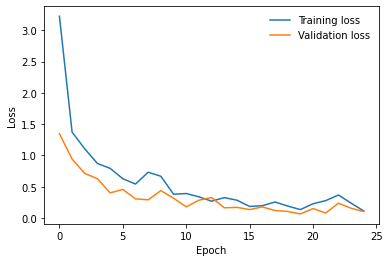

In [ ]:
# 0.003 15 epoch the best
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
train_acc = [x.cpu() for x in train_acc]
val_acc = [x.cpu() for x in val_acc]

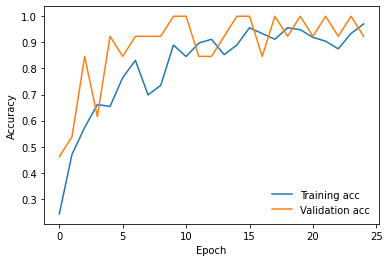

In [ ]:
# 0.003 15 epoch the best
import matplotlib.pyplot as plt
plt.plot(train_acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

# Test model on image

In [ ]:
import torch
model_pth = '/content/drive/MyDrive/kinect_data/KARD_data/model_saved/'
model=torch.load(model_pth+'Mymodel_003_dataset_scale.pth')
model.eval()

In [ ]:
from torchvision import transforms

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Put images and labels from test dataset to arrays

In [ ]:
images = []
labels = []
for image,label in test_data:
  images.append(image)
  labels.append(label)

In [ ]:
classes = ['Bend', 'Hand Clap', 'Walk', 'Sit down', 'Stand up']

## Test data with just 244*... dimention 

### Model

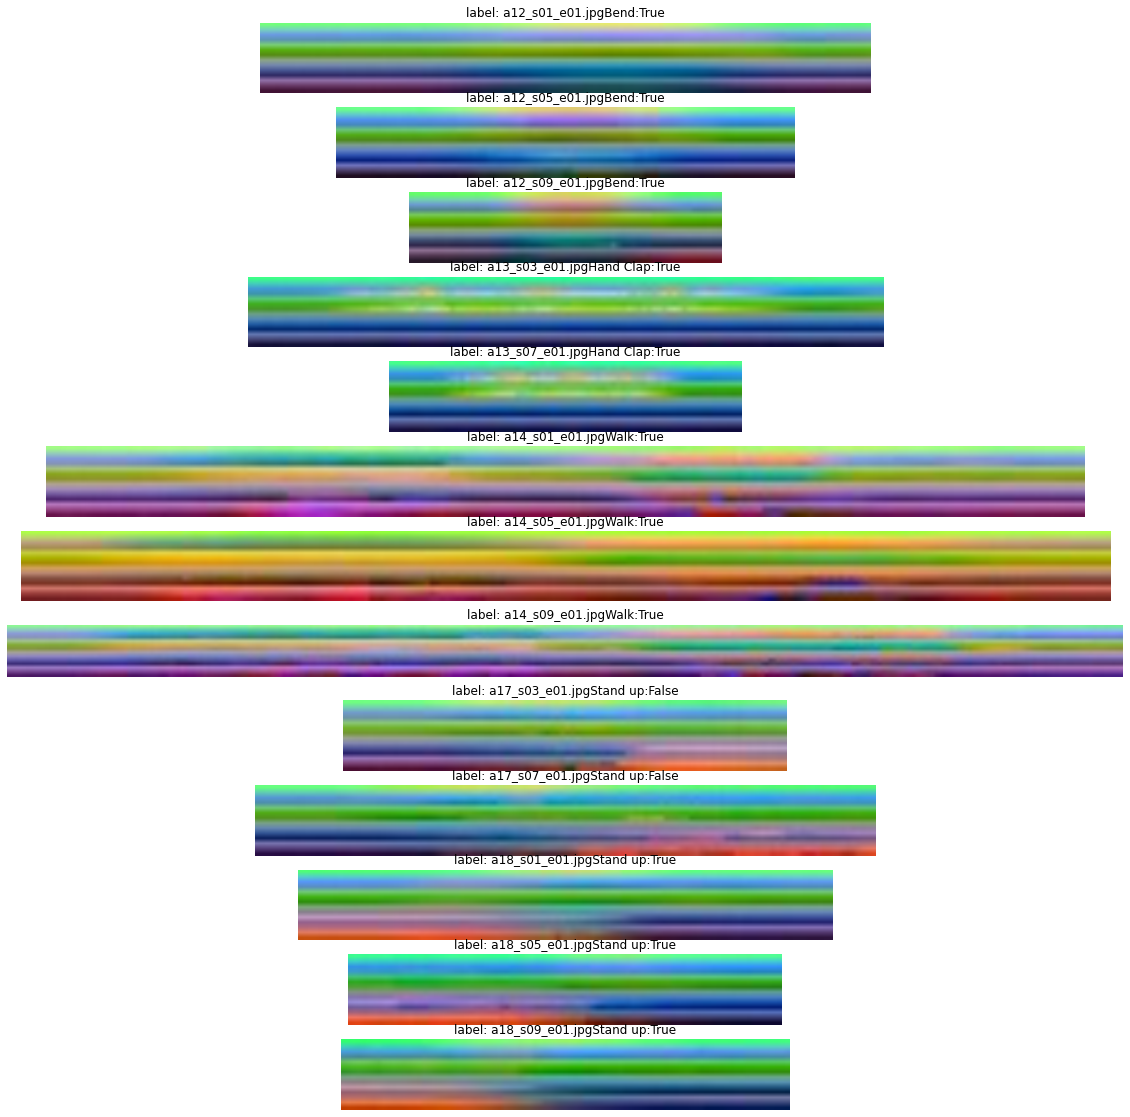

In [ ]:
#first
import matplotlib.pyplot as plt

res_acc = []
to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    sub = fig.add_subplot(len(images), 1, ii+1)
    res = int(labels[ii]) == index
    res_acc.append(res)
    sub.set_title(
        'label: '+test_data.imgs[ii][0].split('/')[-1]+str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
100*sum(res_acc)/len(res_acc)

84.61538461538461